# ABS tutorial 01

## assembling the ABS pipeline

In this tutorial we first write a simple data processing pipeline manually and show when and how ABS method comes into the CMB extraction, then with the built-in pipeline, we should be able to get the same results.

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

In [1]:
import numpy as np
import matplotlib
import healpy as hp
import logging as log
import abspy as ap  # <---------- the ABSpy module
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#log.basicConfig(filename='abspy_tutorial02.log', level=log.DEBUG)

### generate maps with pysm3

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30 = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95 = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150 = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353 = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353+mapcmb,fwhm=fwhm[3])

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


- full sky maps (by adding up synchrotron, thermal dust and CMB proivded by PySM)

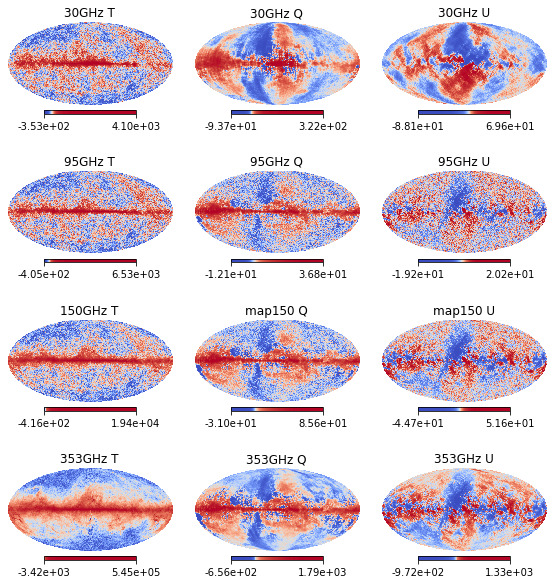

In [3]:
fig = matplotlib.pyplot.figure(figsize=(10,10))
gs = matplotlib.gridspec.GridSpec(55, 30)

fig.add_subplot(gs[0:10, 0:10])
hp.mollview(map30[0],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='30GHz T',cbar=1)
fig.add_subplot(gs[0:10, 10:20])
hp.mollview(map30[1],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='30GHz Q',cbar=1)
fig.add_subplot(gs[0:10, 20:30])
hp.mollview(map30[2],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='30GHz U',cbar=1)

fig.add_subplot(gs[15:25, 0:10])
hp.mollview(map95[0],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='95GHz T',cbar=1)
fig.add_subplot(gs[15:25, 10:20])
hp.mollview(map95[1],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='95GHz Q',cbar=1)
fig.add_subplot(gs[15:25, 20:30])
hp.mollview(map95[2],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='95GHz U',cbar=1)

fig.add_subplot(gs[30:40, 0:10])
hp.mollview(map150[0],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='150GHz T',cbar=1)
fig.add_subplot(gs[30:40, 10:20])
hp.mollview(map150[1],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='map150 Q',cbar=1)
fig.add_subplot(gs[30:40, 20:30])
hp.mollview(map150[2],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='map150 U',cbar=1)

fig.add_subplot(gs[45:55, 0:10])
hp.mollview(map353[0],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='353GHz T',cbar=1)
fig.add_subplot(gs[45:55, 10:20])
hp.mollview(map353[1],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='353GHz Q',cbar=1)
fig.add_subplot(gs[45:55, 20:30])
hp.mollview(map353[2],format='%.2e',
            norm='hist',cmap='coolwarm',hold=True,title='353GHz U',cbar=1)

### use `abspipe` (short for ABS pipeline) with map matrix input

### `abspipe` (initialization/instantiation) Parameters: 

**singals** : dict
> The full collection of measurements in pixel domain,
  arranged in form {frequency (GHz): array(N_map, N_pixel)}.
    - N_map: number of maps at each frequency
    - N_pixel: number of pixels of each map
    
**variances** : dict
> The measured noise variance maps,
  should be arranged in the same shape as **signal**.
  By default, no variance maps required.
  
**mask** : numpy.ndarray
> Single mask map,
  should be arranged in shape: (1, N_pixel),
  By default is None, which means no masking.

**fwhms** : list
> Gaussian beams with given FWHM at each frequency band
            
**lmax** : integer
> Maximal multiple in PS estimation.

### the `__call__` or `abspipe::run()` function parameters:

**aposcale** : float
> Apodization scale for PS estimation.

**psbin** : integer
> number of angular modes in each $\ell$-bin for pseudo-$C_\ell$ estimation

**shift** : float
> ABS method (CMB signal) shift parameter.

**threshold** : float
> ABS method signal-to-noise threshold parameter.

### `abspipe::__call__` or `abspipe::run()` returns

**result** : numpy.ndarray
> The first row contains angular mode positions, while the second row contains the PS band power $D_\ell$ at corresponding multipoles.

> If `verbose=True`, then the **result** contains an extra dictionary of eigen values and eigen vectors for each multipole, in form {multipole index : (eigen values, eigen vectors)}.

- apply to T maps

CPU times: user 27.6 s, sys: 76 ms, total: 27.6 s
Wall time: 7.5 s


(1, 384)

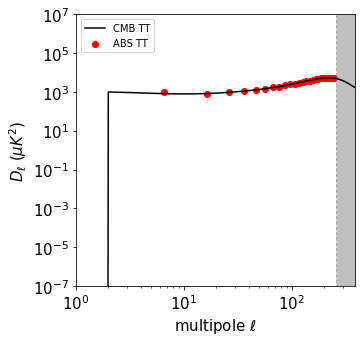

In [4]:
%%time

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)
fullmap[353] = map353[0].reshape(1,-1)

pipeline = ap.abspipe(fullmap,fwhms=fwhm)
rslt_tt = pipeline(aposcale=6.,psbin=10,shift=None,threshold=None,verbose=True)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_tt[0],rslt_tt[1],
           color='red',marker='o',label=r'ABS TT')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[0],
        color='black',linestyle='-',label=r'CMB TT')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

check the eigens in cross-correlated PS band power

the eigen values and vectors are returned as a python dict, attached to the normal return of pipeline's `__call__` function, in form: `{mode #: (eigen value, eigen vector)}`

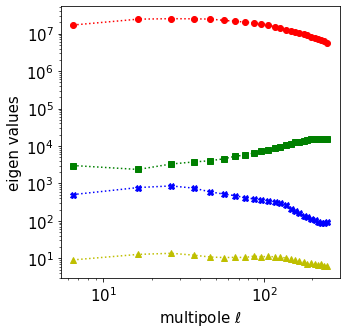

In [5]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))
freq_list = [30,95,150,353]

eigens = np.empty((len(freq_list),len(rslt_tt[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_tt[-1][i][0]

ax.plot(rslt_tt[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_tt[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_tt[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_tt[0],eigens[3],linestyle=':',color='y',marker='^')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

- check with Q,U maps

CPU times: user 1min 47s, sys: 759 ms, total: 1min 48s
Wall time: 28.4 s


(1, 384)

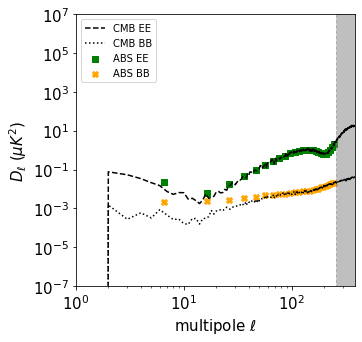

In [6]:
%%time

fullmap.clear()
fullmap[30] = map30[1:3]
fullmap[95] = map95[1:3]
fullmap[150] = map150[1:3]
fullmap[353] = map353[1:3]

pipeline = ap.abspipe(fullmap,fwhms=fwhm)
rslt_eb = pipeline(aposcale=6.,psbin=10,shift=None,threshold=None)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_eb[0],rslt_eb[1],
           color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],rslt_eb[2],
           color='orange',marker='X',label=r'ABS BB')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[1],
        color='black',linestyle='--',label=r'CMB EE')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

B mode only, with EB leakage correction done before PS estimation

CPU times: user 1min 1s, sys: 176 ms, total: 1min 1s
Wall time: 15.7 s


(1, 384)

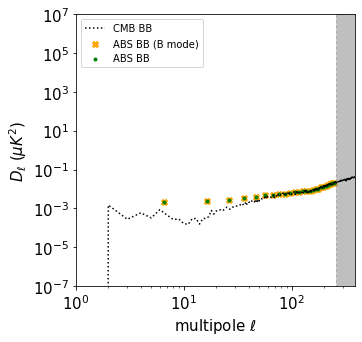

In [7]:
%%time

fullmap.clear()
fullmap[30] = map30
fullmap[95] = map95
fullmap[150] = map150
fullmap[353] = map353

pipeline = ap.abspipe(fullmap,fwhms=fwhm)
rslt_b = pipeline.run_bmode(aposcale=6.,psbin=10,shift=None,threshold=None)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_b[0],rslt_b[1],
           color='orange',marker='X',label=r'ABS BB (B mode)')

ax.scatter(rslt_eb[0],rslt_eb[2],
           color='green',marker='.',label=r'ABS BB')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

### comments:

The "bias" seen at low multiple B mode spectrum appears to be caused by the Milky Way contamination.

end